In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
from os import listdir
sessions_df = pd.read_csv("data_toolkit/data/sessions.csv")
practices_df = pd.read_csv("data_toolkit/data/practices.csv")
ccgs_df = pd.read_csv("data_toolkit/data/ccgs.csv")

In [3]:
sessions_df.count()

id                      128618
practice_id             128618
posted_datetime         128618
start_datetime          128618
end_datetime            128618
hourly_rate             128618
original_hourly_rate     87316
status                  128618
locum_id                 47732
dtype: int64

In [4]:
import datetime

length_seconds = lambda row: (row['end_datetime'] - row['start_datetime']).total_seconds()
one_hour = 60 * 60
is_short = lambda row: row['length_seconds'] <= 2 * one_hour
is_medium = lambda row: 2 * one_hour < row['length_seconds'] <= 4 * one_hour
is_long = lambda row: 4 * one_hour < row['length_seconds']


# These methods may exclude sessions that are very very long, but those
# appear to be outliers. Keeping it simple. 
def at_night(row): 
    return row['start_datetime'].time() >= datetime.time(18) or \
           row['end_datetime'].time() <= datetime.time(8)
   
   
def at_morning(row):
    start_in_morning = datetime.time(11) >= row['start_datetime'].time() >= datetime.time(6)
    end_in_morning = datetime.time(8) >= row['end_datetime'].time() >= datetime.time(12)
    if start_in_morning or end_in_morning:
        return True
    else:
        return False
    

def at_afternoon(row):
    start_in_aft = datetime.time(16) >= row['start_datetime'].time() > datetime.time(12)
    end_in_aft = datetime.time(20) >= row['end_datetime'].time() >= datetime.time(15)
    if start_in_aft or end_in_aft:
        return True
    else:
        return False
    
def is_on_day_of_week_partial(day_of_week):
    def is_on_day_of_week(row):
        if row['start_datetime'].weekday() == day_of_week:
            return True
        else:
            return False
    return is_on_day_of_week

In [5]:
# Transform data
# Add new features that come from the session time
sessions_df['start_datetime'] = pd.to_datetime(sessions_df['start_datetime'])
sessions_df['end_datetime'] = pd.to_datetime(sessions_df['end_datetime'])

sessions_df['length_seconds'] = sessions_df[['start_datetime', 'end_datetime']].apply(
    length_seconds, axis=1
)
sessions_df['is_short'] = sessions_df[['length_seconds']].apply(
    is_short, axis=1
)
sessions_df['is_medium'] = sessions_df[['length_seconds']].apply(
    is_medium, axis=1
)
sessions_df['is_long'] = sessions_df[['length_seconds']].apply(
    is_long, axis=1
)

sessions_df['at_night'] = sessions_df[['start_datetime', 'end_datetime']].apply(
    at_night, axis=1
)
sessions_df['at_afternoon'] = sessions_df[['start_datetime', 'end_datetime']].apply(
    at_afternoon, axis=1
)
sessions_df['at_morning'] = sessions_df[['start_datetime', 'end_datetime']].apply(
    at_morning, axis=1
)

sessions_df['monday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(0), axis=1
)
sessions_df['tuesday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(1), axis=1
)
sessions_df['wednesday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(2), axis=1
)
sessions_df['thursday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(3), axis=1
)
sessions_df['friday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(4), axis=1
)
sessions_df['saturday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(5), axis=1
)
sessions_df['sunday'] = sessions_df[['start_datetime']].apply(
    is_on_day_of_week_partial(6), axis=1
)

In [6]:
# Clean data
# We care about Completed / Filled / Expired sessions
clean_df = sessions_df[
    (sessions_df.status == 'completed') |
    (sessions_df.status == 'expired') |
    (sessions_df.status == 'filled')
]
clean_df['filled'] = clean_df[['status']].apply(
    lambda row: row['status'] in ['completed', 'filled'], axis=1
)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
display(clean_df.describe())

,id,practice_id,hourly_rate,original_hourly_rate,locum_id,length_seconds
count,7.187300e+04,7.187300e+04,71873.000000,56544.000000,4.391500e+04,71873.000000
mean,3.686400e+08,2.139361e+06,81.944086,82.027766,1.522447e+07,17365.769379
std,1.033498e+08,1.279175e+06,7.199402,6.891379,5.001106e+07,8211.822889
min,4.016688e+07,3.011200e+04,60.000000,1.850000,2.011000e+04,7200.000000
25%,4.011212e+08,3.019170e+05,80.000000,80.000000,2.012139e+06,10800.000000
50%,4.011550e+08,3.011153e+06,80.000000,80.000000,2.013710e+06,14400.000000
75%,4.011850e+08,3.011767e+06,85.000000,85.000000,2.015509e+06,21600.000000
max,4.012203e+08,3.012808e+06,150.000000,150.000000,2.017111e+08,50400.000000


In [8]:
# merge ccg ids into the dataframe
clean_df = pd.merge(clean_df, practices_df, left_on='practice_id', right_on='id')

In [9]:
clean_df.loc[clean_df['locum_id'].isnull(), 'locum_id'] = 0

In [10]:
time_of_day = ['at_morning', 'at_afternoon', 'at_night']
session_length = ['is_short', 'is_medium', 'is_long']
days_of_week = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

import itertools
time_combinations = list(itertools.product(time_of_day, session_length, days_of_week))
time_combination_dfs = []

for time_combination in time_combinations: 
    one_time_df = clean_df[
        (clean_df[time_combination[0]] == True) &
        (clean_df[time_combination[1]] == True) &
        (clean_df[time_combination[2]] == True)
    ]
    time_combination_dfs.append(one_time_df)

In [11]:
import itertools
rate_range = list(range(60, 130))
comparable_df = pd.DataFrame(columns=itertools.chain(
   ["{}filled".format(str(r)) for r in rate_range],
   ["{}unfilled".format(str(r)) for r in rate_range],
))

In [16]:
rate_deltas_list = list(range(1, 11))
rate_deltas = {i: {} for i in rate_deltas_list}

for rate_delta in rate_deltas_list:
    all_total_weights = []
    all_total_ratio_deltas = []
    for hourly_rate in list(range(60, 130 - rate_delta)):
        # list of weights
        weights = []
        # list of filled %s [(before_ratio, after_ratio)]
        ratios = []
        for one_time_df in time_combination_dfs:
           
            rate_delta_df_before = one_time_df[one_time_df['hourly_rate'] == hourly_rate]
            rate_delta_df_after = one_time_df[one_time_df['hourly_rate'] == hourly_rate + rate_delta]
            
            before_filled = rate_delta_df_before[rate_delta_df_before['filled'] == True].count()[0]
            after_filled = rate_delta_df_after[rate_delta_df_after['filled'] == True].count()[0]
            before_unfilled = rate_delta_df_before[rate_delta_df_before['filled'] == False].count()[0]
            after_unfilled = rate_delta_df_after[rate_delta_df_after['filled'] == False].count()[0]
            
            before = before_filled + before_unfilled
            after = after_filled + after_unfilled
            weight = min(before, after)
            weights.append(weight)
            
            if before_unfilled == 0 or before_filled == 0:
                before_ratio = 0
            else:
                before_ratio = before_filled / before
            
            if after_unfilled == 0 or after_filled == 0:
                after_ratio = 0
            else:
                after_ratio = after_filled / after
            ratios.append((before_ratio, after_ratio))
        
        total_weight = sum(weights)
        all_total_weights.append(total_weight)
        ratio_delta = sum([(weight/total_weight) * (after_ratio - before_ratio) if total_weight > 0 else 0
                           for weight, (before_ratio, after_ratio) 
                           in zip(weights, ratios)])
        rate_deltas[rate_delta][hourly_rate] = ratio_delta
        all_total_ratio_deltas.append(ratio_delta)
        
    total_weight = sum(all_total_weights)
    ratio_delta = sum([(weight/total_weight) * ratio_delta if total_weight > 0 else 0
                       for weight, ratio_delta
                       in zip(all_total_weights, all_total_ratio_deltas)])
    rate_deltas[rate_delta]['weight'] = total_weight
    rate_deltas[rate_delta]['weighted_delta'] = ratio_delta

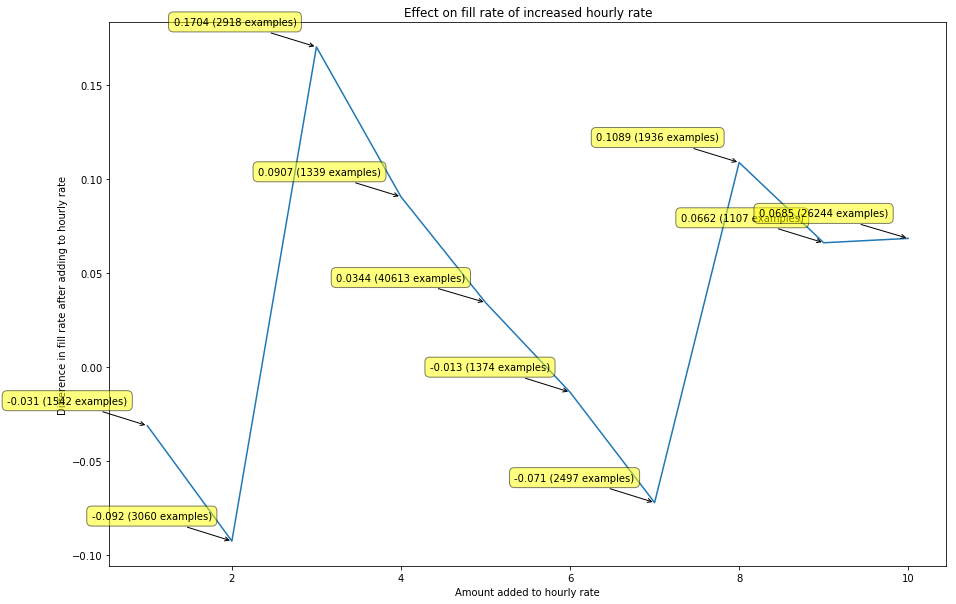

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.set_ylabel("Difference in fill rate after adding to hourly rate")
ax.set_xlabel("Amount added to hourly rate")
ax.set_title("Overall effect on fill rate of increased hourly rate")
y_axis = [rate_deltas[i]['weighted_delta'] for i in rate_deltas_list]
plt.plot(
    rate_deltas_list,
    y_axis
)
labels = ["{} ({} examples)".format(str(rate_deltas[i]['weighted_delta'])[:6], rate_deltas[i]['weight']) 
          for i in rate_deltas_list]
for label, x, y in zip(labels, rate_deltas_list, y_axis):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0')
    )

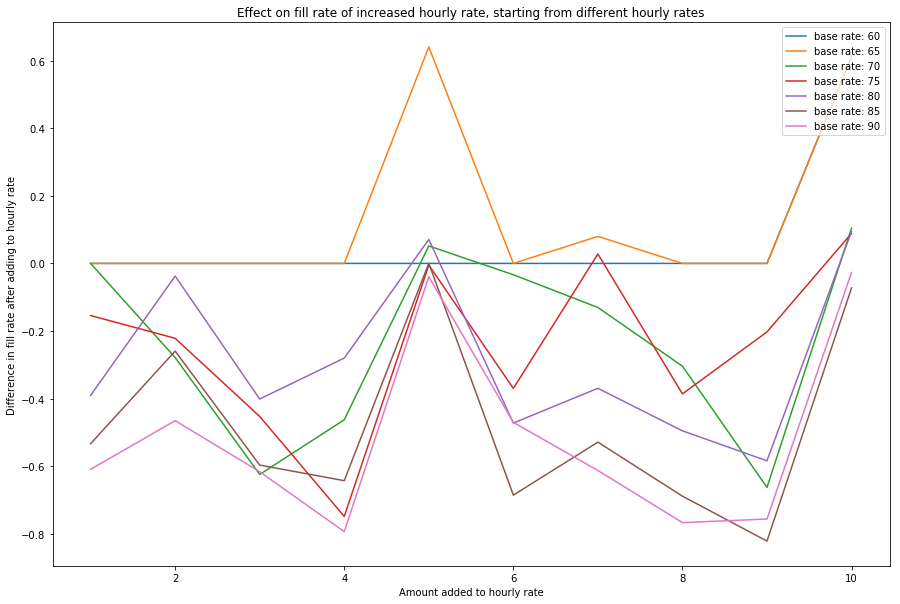

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.set_ylabel("Difference in fill rate after adding to hourly rate")
ax.set_xlabel("Amount added to hourly rate")
ax.set_title("Effect on fill rate of increased hourly rate, starting from different hourly rates")
hourly_rates = list(range(60, 91, 5))

for hourly_rate in hourly_rates:
    y_axis = [rate_deltas[i][hourly_rate] for i in rate_deltas_list]
    plt.plot(
        rate_deltas_list,
        y_axis,
        label="base rate: {}".format(hourly_rate)
    )
plt.legend(loc="upper right")